In [72]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
%matplotlib inline

In [34]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [35]:
# Calculate the median of the insurance_cost column
median_insurance_cost = df['insurance_cost'].median()

# Create the insurance_cost_binary column
df['insurance_cost_binary'] = (df['insurance_cost'] > median_insurance_cost).astype(int)


# Drop the original insurance_cost column
df.drop('insurance_cost', axis=1, inplace=True)

# Display the first few rows of the DataFrame to verify changes
print(df.head())


   age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                      0
1   18    male  34.100         0     no  southeast                      0
2   18  female  26.315         0     no  northeast                      0
3   18  female  38.665         2     no  northeast                      0
4   18  female  35.625         0     no  northeast                      0


In [36]:
df['insurance_cost_binary'].value_counts()

insurance_cost_binary
0    669
1    669
Name: count, dtype: int64

In [37]:
df.isna().sum()

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

In [38]:
df[['age', 'bmi', 'children']].describe()

age          bmi     children
count  1338.000000  1338.000000  1338.000000
mean     39.207025    30.663397     1.094918
std      14.049960     6.098187     1.205493
min      18.000000    15.960000     0.000000
25%      27.000000    26.296250     0.000000
50%      39.000000    30.400000     1.000000
75%      51.000000    34.693750     2.000000
max      64.000000    53.130000     5.000000

<Axes: >

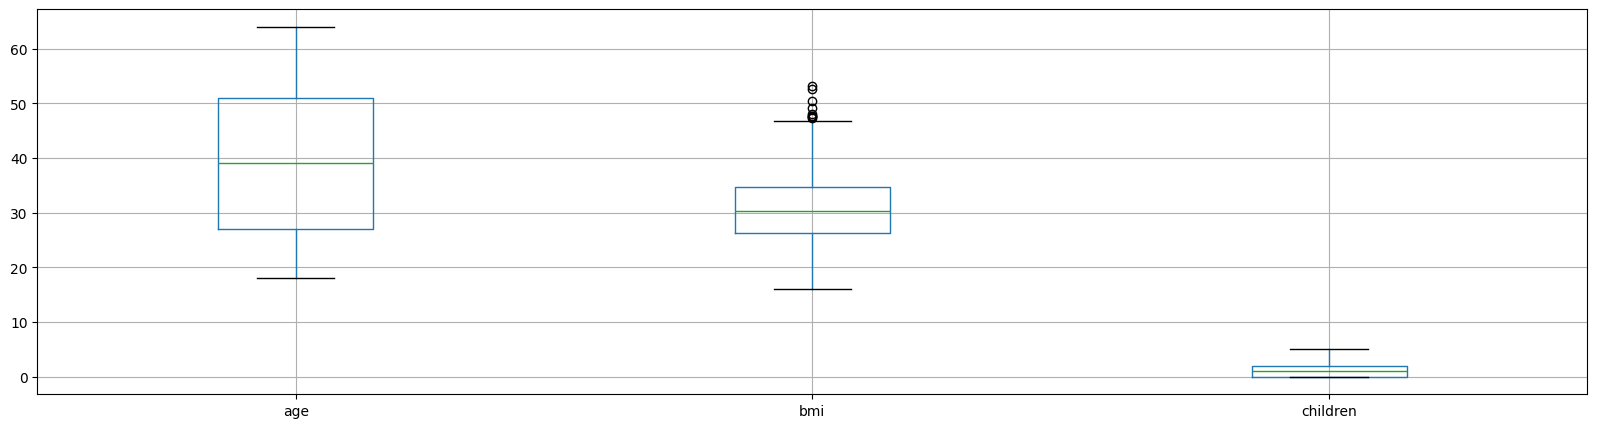

In [39]:
df[['age', 'bmi', 'children']].boxplot(figsize=(20,5))

Bmi has outliers, while age and children don't. In that case I will use RobustScalar on bmi and StandardScalar on the other 2.

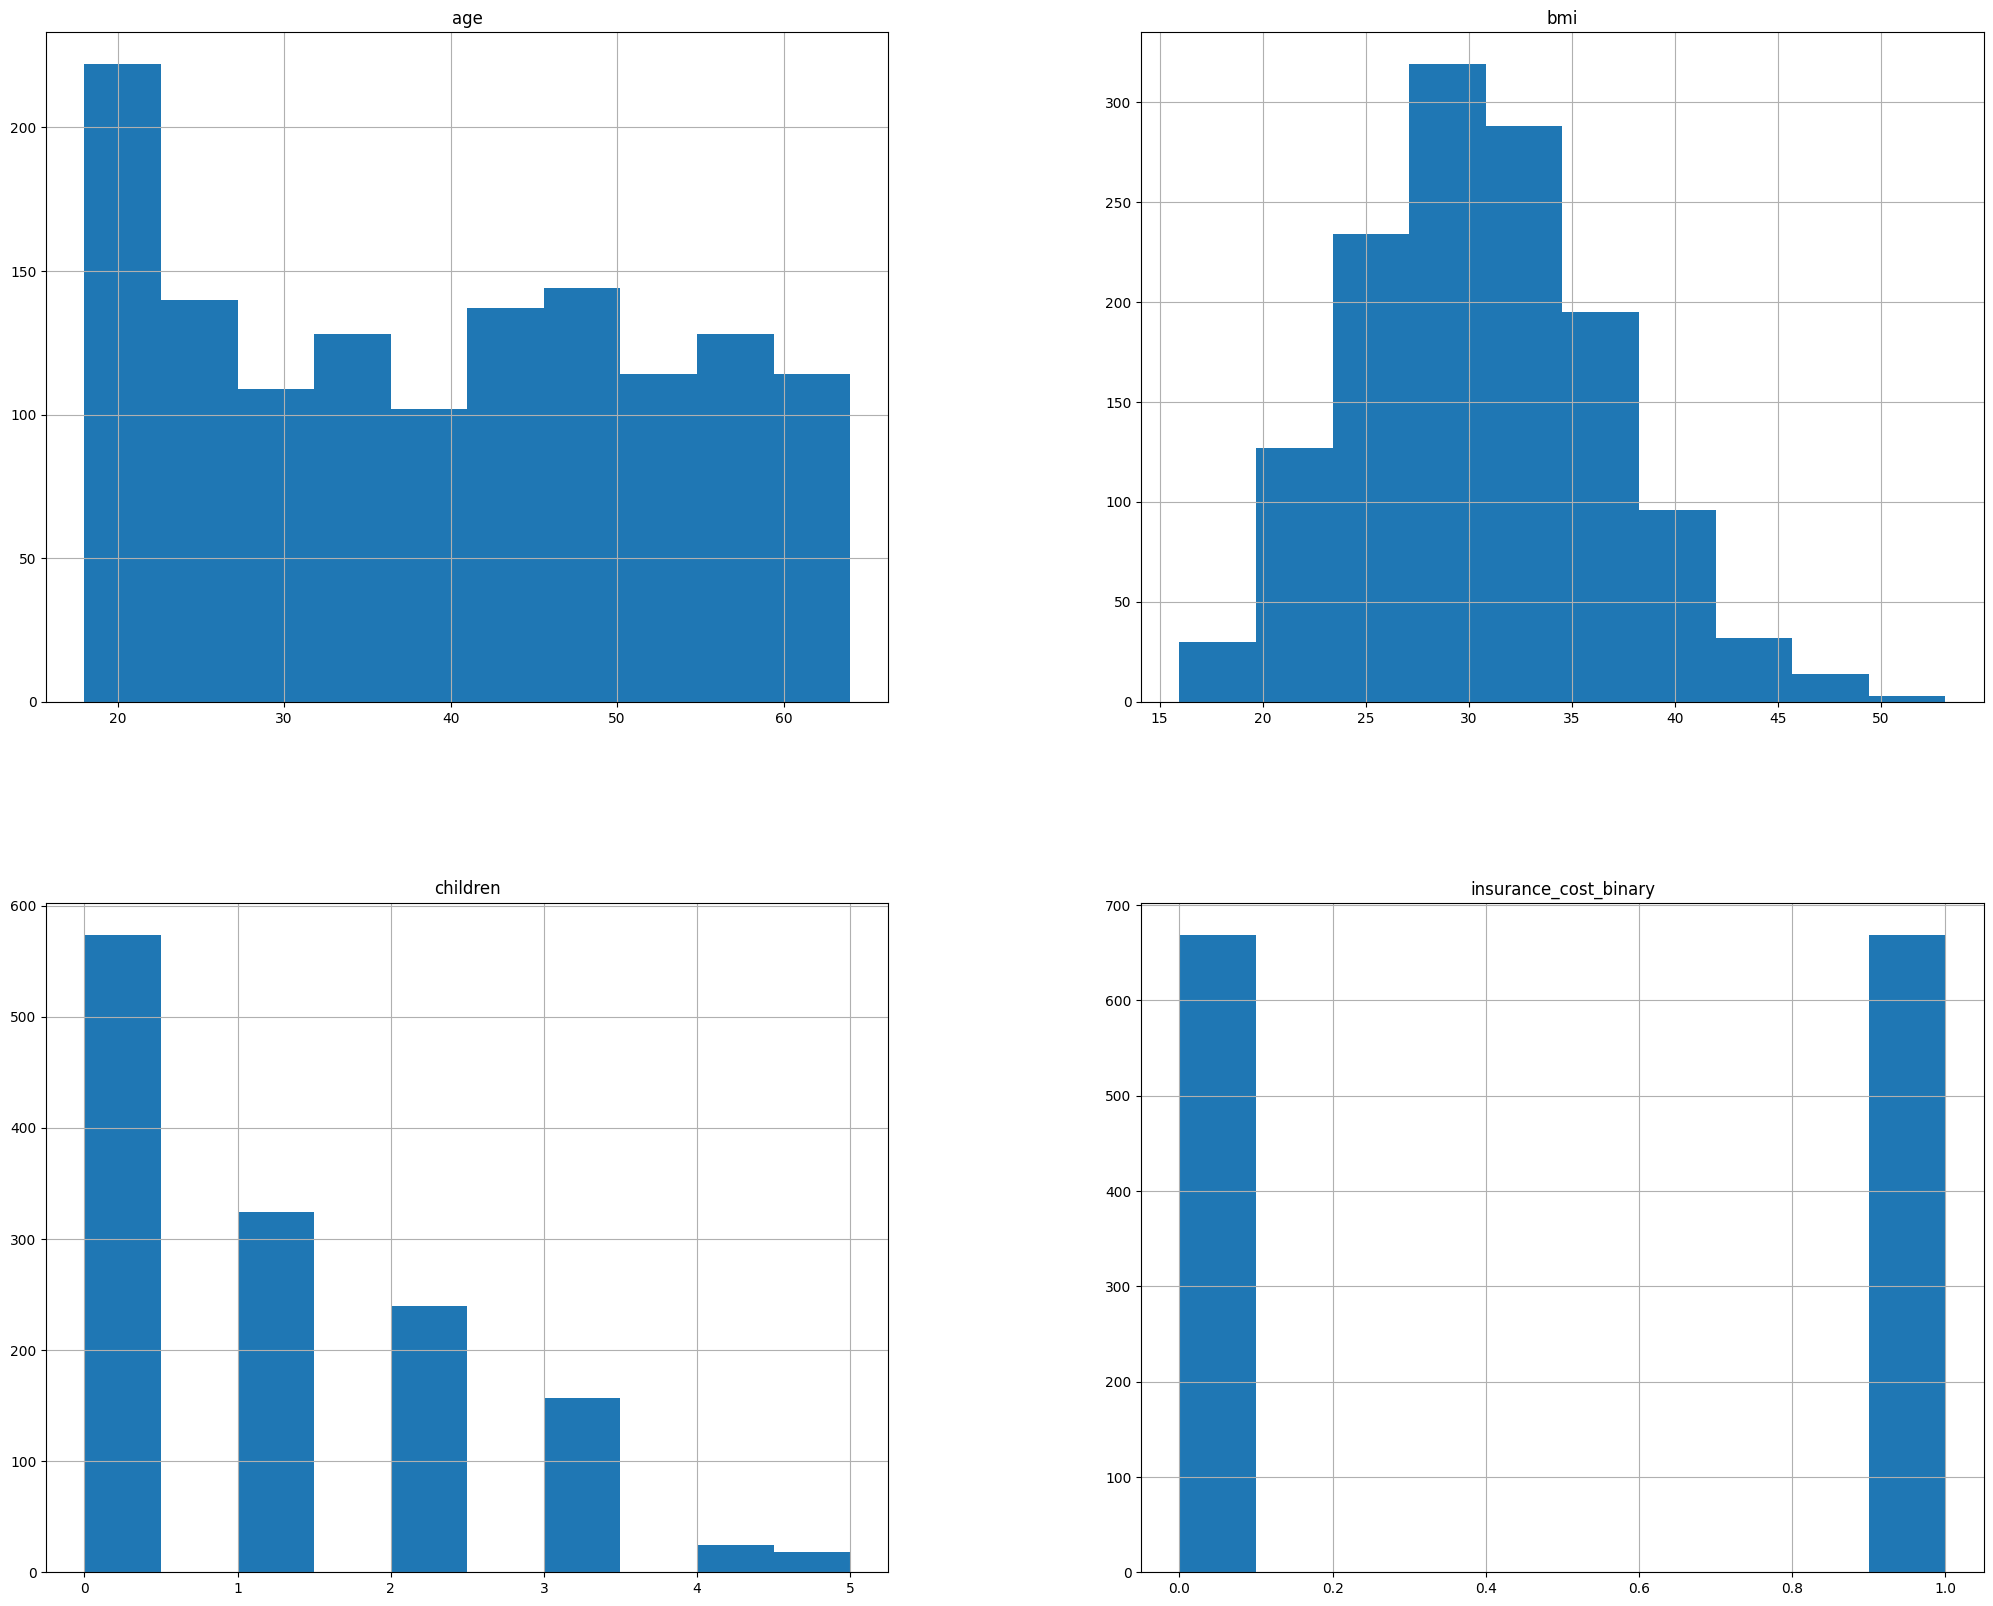

In [40]:
df.hist(bins=10, figsize=(25, 20));

The age and bmi columns can be transformed with log transformation. Children, with its zero values, will need to be transformed another way. 

In [41]:
# Applying the square root transformation
df['children_sqrt'] = np.sqrt(df['children'])

<Axes: >

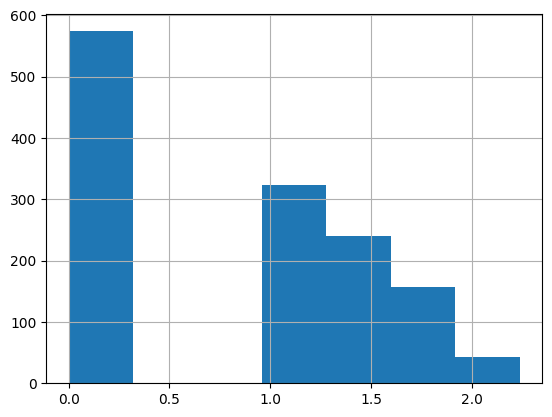

In [42]:
df['children_sqrt'].hist(bins=7)

In [43]:
# Applying the cube root transformation
df['children_cbrt'] = np.cbrt(df['children'])

<Axes: >

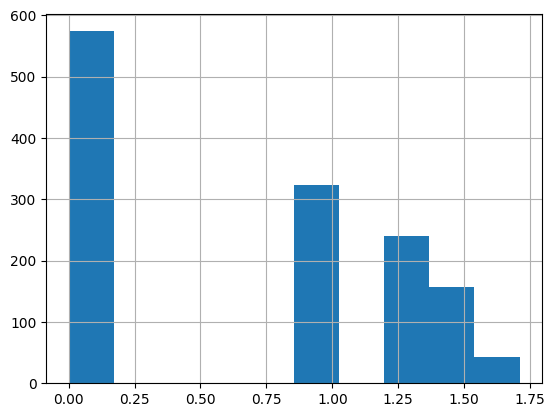

In [44]:
df['children_cbrt'].hist(bins=10)

In [45]:
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)

In [46]:
# group 1
columns_no_outliers = ['age', 'children']

In [47]:
# group 2
columns_outliers= ['bmi']

In [48]:
# group 3
columns_zeros= ['children']

So, I want to scale age and bmi with log transformation, children with cube root. I need to deal with outliers separately. So I think each column will end up with their own pipeline

In [49]:
age_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log)), 
        ("scaler", StandardScaler())
    ]
)

bmi_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log)),
        ("scaler", RobustScaler())
    ]
)

children_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt)),
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("age", age_pipeline, ["age"]),
        ("bmi", bmi_pipeline, ["bmi"]),
        ("children", children_pipeline, ["children"])
    ]
)

In [79]:
# Dimensionality Reduction: PCA
pca = PCA(n_components=3)  # Adjust n_components based on variance ratio

# Feature Selection: RFE
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=2)

# Further Feature Selection: SelectFromModel
select_from_model = SelectFromModel(GradientBoostingClassifier(), threshold='median')


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [81]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('feature_selector', rfe),
    ('model_selector', select_from_model),
    ('svm', SVC())  
])

In [82]:
set_config(display="diagram")
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('bmi',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('children',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['children'])])),
                ('pca', PCA(n_components=3)),
                ('feature_selector',
                 RFE(estimator=LogisticRegression(), n_features_to_select=2)),
                ('model_selector',
                 SelectFromModel(estimator=GradientBoostingClassifier(),
                                 threshold='median')),
                ('svm', SVC())])

In [83]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(full_pipeline, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.698:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


## Random Forest

In [84]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('feature_selector', rfe),
    ('model_selector', select_from_model),
    ('rf', RandomForestClassifier())  
])

In [85]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(full_pipeline, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.702:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 10}


## MLPClassifier

In [91]:
from sklearn.neural_network import MLPClassifier
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('feature_selector', rfe),
    ('model_selector', select_from_model),
    ('classifier', MLPClassifier(max_iter=1000))
])

In [93]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate_init': [0.001, 0.01]
}


search = GridSearchCV(full_pipeline, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.706:
Best parameters:  {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate_init': 0.001, 'classifier__solver': 'adam'}
